## Generating Semantic Segmentation images

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
region = 'x03'
comp = 'PCA'

In [3]:
model = torch.load(f'models/UMDA_Compositions-DeepLabV3Plus-{comp}.pth')

/home/ebneto/miniconda3/envs/smp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
image = Image.open(f'dataset/scenes_pca/pca_{region}.png')
image = np.array(image, dtype=np.float32)
# image = np.load(f'dataset/scenes_allbands_ndvi/allbands_ndvi_{region}.npy')[:, :, :]
height, width, _ = image.shape
print(image.shape)

(998, 977, 3)


In [5]:
# image = Image.fromarray(image.astype(np.uint8))
# image = image.crop((0, 0, 768, 768))
# image.save(f'outputs/{region}_RGB.png')

In [6]:
patch_size = (256, 256)
stride = 256 

In [7]:
predicted_masks = []
patch_counts = []

In [8]:
# Iterate through patches
for y in range(0, height - patch_size[1], stride):
    for x in range(0, width - patch_size[0], stride):
        # Crop the patch from the input image
        patch = image[y:y + patch_size[1], x:x + patch_size[0], :]
        patch = torch.tensor((np.transpose(patch, (2, 0, 1))/ 255.0), device='cuda')

        # Make predictions using the model
        with torch.no_grad():
            predicted_mask = model(patch.unsqueeze(0))  # Add batch dimension
            # print(predicted_mask.shape)

        # Convert the predicted mask to a numpy array
        predicted_mask = predicted_mask.squeeze().cpu().numpy()

        # Store the predicted mask and patch count
        predicted_masks.append(predicted_mask)
        patch_counts.append((x, y))

In [9]:
# Create an empty result image with the same size as the input image
concatenated_pred = np.zeros((y + patch_size[1], x + patch_size[0]))

# Create an empty mask with the same size as the patches
mask_accumulator = np.zeros((y + patch_size[1], x + patch_size[0]))

# Combine the predicted masks into the result image
for mask, (x, y) in zip(predicted_masks, patch_counts):
    x1, x2 = x, x + patch_size[0]
    y1, y2 = y, y + patch_size[1]

    # Clip the patch and mask to fit within the image boundaries
    x1, x2 = max(0, x1), min(width, x2)
    y1, y2 = max(0, y1), min(height, y2)

    # Calculate the clipped patch dimensions
    patch_width = x2 - x1
    patch_height = y2 - y1

    # Calculate the corresponding mask region
    mask_region = mask[:patch_height, :patch_width]

    # Add the mask region to the accumulator
    mask_accumulator[y1:y2, x1:x2] += mask_region

# Set a threshold for the final mask if needed
threshold = 0.5  # Adjust as needed

# Apply the threshold to the mask accumulator to get the final result
concatenated_pred = np.where(mask_accumulator >= threshold, 1, 0)

# Create a PIL image from the result
concatenated_pred = Image.fromarray((concatenated_pred * 255).astype(np.uint8))

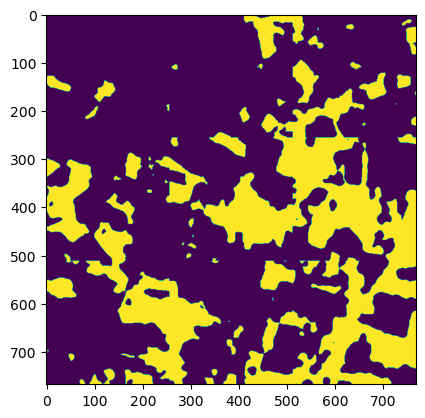

In [10]:
# preview result
plt.imshow(concatenated_pred)

In [11]:
concatenated_pred = np.array(concatenated_pred) / 255
# concatenated_pred = concatenated_pred.astype(np.uint8)

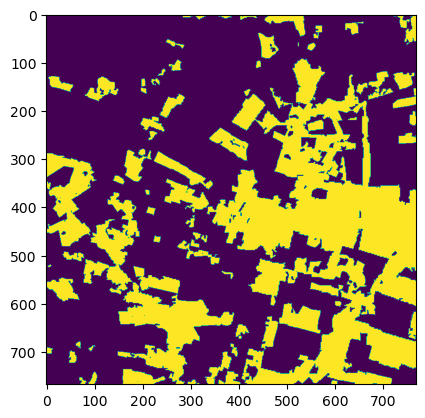

In [12]:
# load truth mask
truth_mask = np.load(f'dataset/truth_masks/truth_{region}.npy')
truth_mask = truth_mask[:y+patch_size[1], :x+patch_size[0]]
plt.imshow(truth_mask)

In [13]:
# concatenated_pred = np.expand_dims(concatenated_pred, axis=2)
truth_mask = np.squeeze(truth_mask)

In [14]:
# Define color mappings
true_positive_color = [255, 255, 255]  # White
true_negative_color = [0, 0, 0]        # Black
false_positive_color = [0, 0, 255]     # Blue
false_negative_color = [255, 0, 0]     # Red

In [15]:
# compare unique values
print(f'unique values in concatenated_pred: {np.unique(concatenated_pred)}')
print(f'unique values in truth_mask: {np.unique(truth_mask)}')

unique values in concatenated_pred: [0. 1.]
unique values in truth_mask: [0 1]


(768, 768)
(768, 768)
(768, 768)
(768, 768)


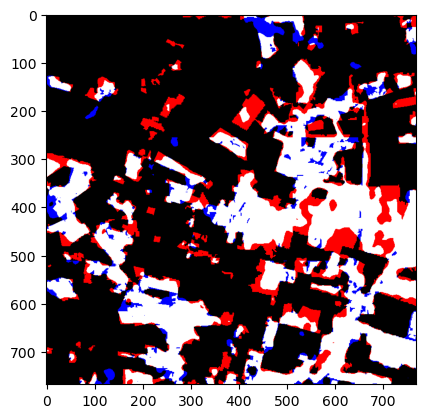

In [16]:
# Initialize an empty result image
result_image = np.zeros(truth_mask.shape + (3,))

# Identify true positives, true negatives, false positives, and false negatives
true_positives = np.logical_and(truth_mask == 1, concatenated_pred == 1)
true_negatives = np.logical_and(truth_mask == 0, concatenated_pred == 0)
false_positives = np.logical_and(truth_mask == 0, concatenated_pred == 1)
false_negatives = np.logical_and(truth_mask == 1, concatenated_pred == 0)

# print their shapes
print(true_positives.shape)
print(true_negatives.shape)
print(false_positives.shape)
print(false_negatives.shape)

# Assign colors to each category in the result image
result_image[true_positives] = true_positive_color
result_image[true_negatives] = true_negative_color
result_image[false_positives] = false_positive_color
result_image[false_negatives] = false_negative_color

# Create a PIL image from the result
result_image = Image.fromarray(result_image.astype(np.uint8))
plt.imshow(result_image)

In [17]:
# save image
result_image.save(f'outputs/confusionMaskSS_{region}_DeepLabV3Plus-{comp}.png')

In [18]:
# save truth mask as png
truth_mask = Image.fromarray((truth_mask * 255).astype(np.uint8))
truth_mask.save(f'outputs/truthMaskSS_{region}.png')